**SPEECH EMOTION RECOGNITION MINOR PROJECT**

Submitted by: Shobheet Pandey

Roll Number: 101916041

In [58]:
#importing required libraries
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile
import glob, pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras.models import Model
from IPython.display import Audio
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Explratory Data Analysis**

In [18]:
ravdess='/content/drive/MyDrive/RAVDESS Dataset/audio_speech_actors_01-24'

In [19]:
ravdess_directory_list = os.listdir(ravdess)
emotion_df = []
for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(ravdess, dir, wav)))

In [20]:
rav_df = pd.DataFrame.from_dict(emotion_df)
rav_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)
rav_df.Emotion.replace({1:'Neutral', 2:'Neutral', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'}, inplace=True)
rav_df.head()

Emotion                                               Path
0  Neutral  /content/drive/MyDrive/RAVDESS Dataset/audio_s...
1  Neutral  /content/drive/MyDrive/RAVDESS Dataset/audio_s...
2      Sad  /content/drive/MyDrive/RAVDESS Dataset/audio_s...
3  Neutral  /content/drive/MyDrive/RAVDESS Dataset/audio_s...
4      Sad  /content/drive/MyDrive/RAVDESS Dataset/audio_s...

In [21]:
rav_df.shape

(1440, 2)

In [22]:
rav_df['Emotion'].value_counts()

Neutral     288
Sad         192
Happy       192
Fear        192
Disgust     192
Angry       192
Surprise    192
Name: Emotion, dtype: int64

In [24]:
#function for waveplot
def waveplot(data,sr,emo):
    plt.figure(figsize=(10,4))
    plt.title(emo, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

#function for spectogram
def spectogram(data,sr,emo):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emo, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

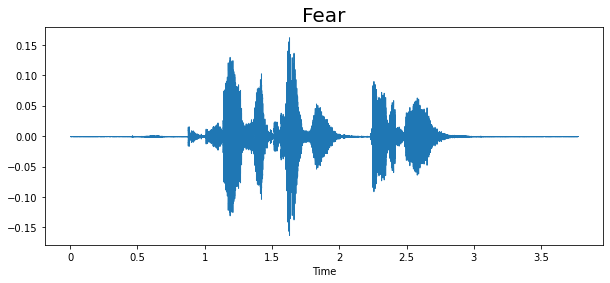

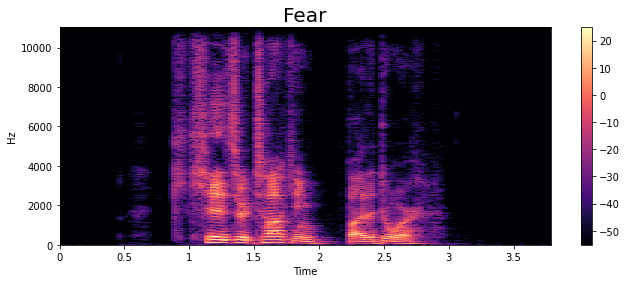

In [27]:
#showing waveplot, spectogram and audio for the emotion "Fear"
emo='Fear'
path = np.array(rav_df['Path'][rav_df['Emotion']==emo])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emo)
spectogram(data, sampling_rate, emo)
Audio(path)

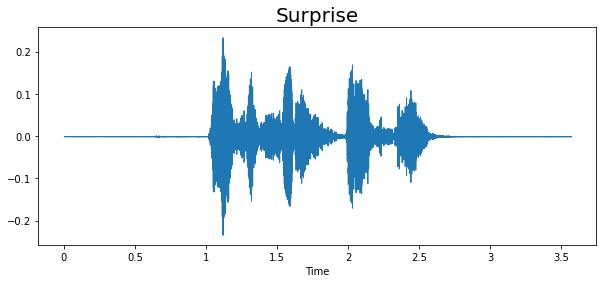

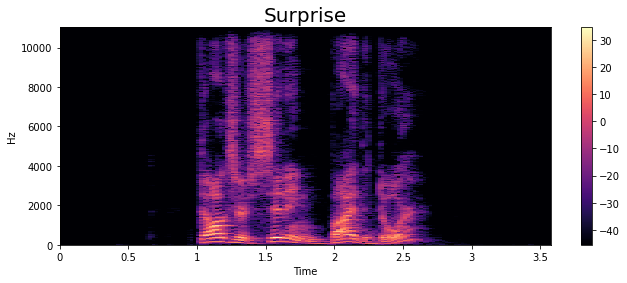

In [28]:
#showing waveplot, spectogram and audio for the emotion "Fear"
emo='Surprise'
path = np.array(rav_df['Path'][rav_df['Emotion']==emo])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emo)
spectogram(data, sampling_rate, emo)
Audio(path)

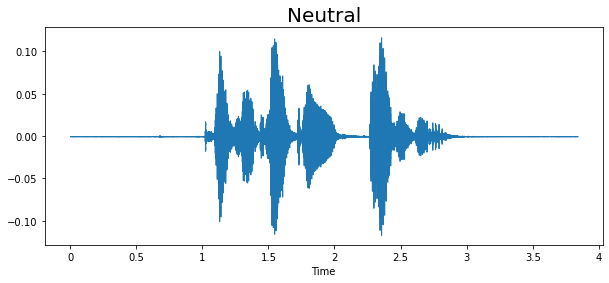

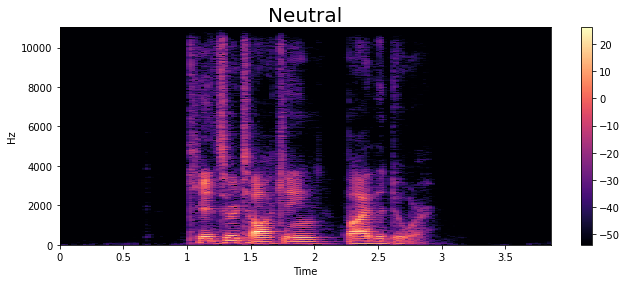

In [29]:
#showing waveplot, spectogram and audio for the emotion "Neutral"
emo='Neutral'
path = np.array(rav_df['Path'][rav_df['Emotion']==emo])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emo)
spectogram(data, sampling_rate, emo)
Audio(path)

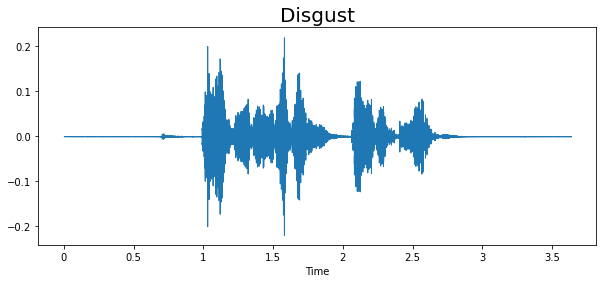

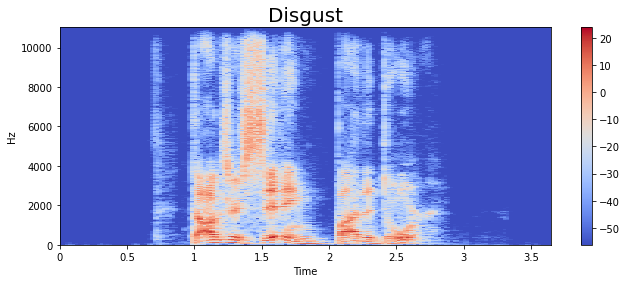

In [30]:
#showing waveplot, spectogram and audio for the emotion "Disgust"
emo='Disgust'
path = np.array(rav_df['Path'][rav_df['Emotion']==emo])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emo)
spectogram(data, sampling_rate, emo)
Audio(path)

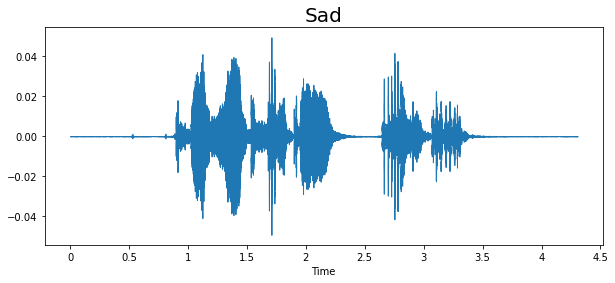

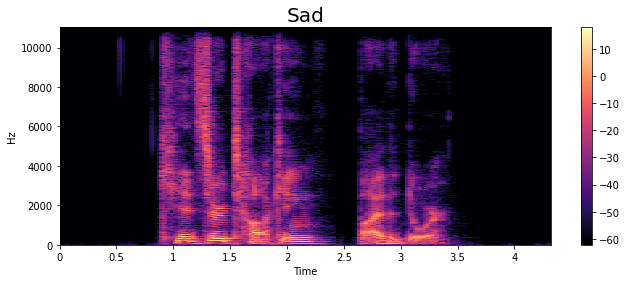

In [31]:
#showing waveplot, spectogram and audio for the emotion "Sad"
emo='Sad'
path = np.array(rav_df['Path'][rav_df['Emotion']==emo])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emo)
spectogram(data, sampling_rate, emo)
Audio(path)

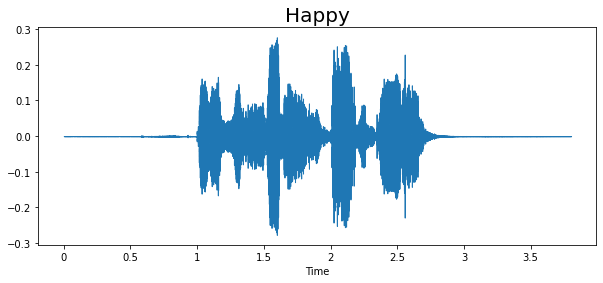

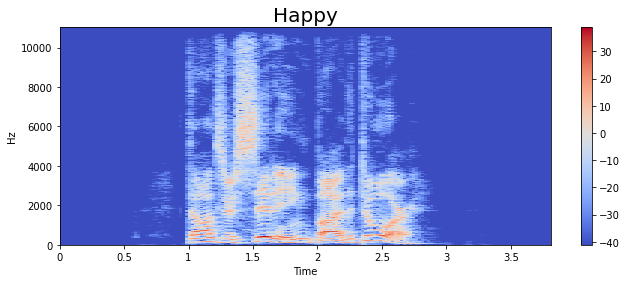

In [32]:
#showing waveplot, spectogram and audio for the emotion "Happy"
emo='Happy'
path = np.array(rav_df['Path'][rav_df['Emotion']==emo])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emo)
spectogram(data, sampling_rate, emo)
Audio(path)

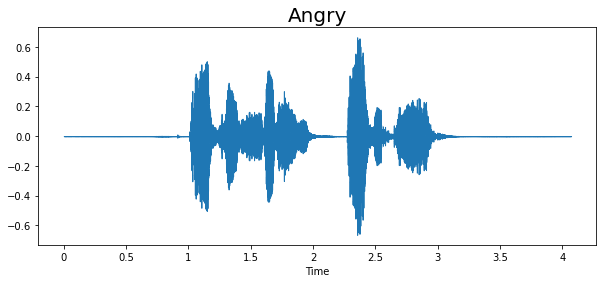

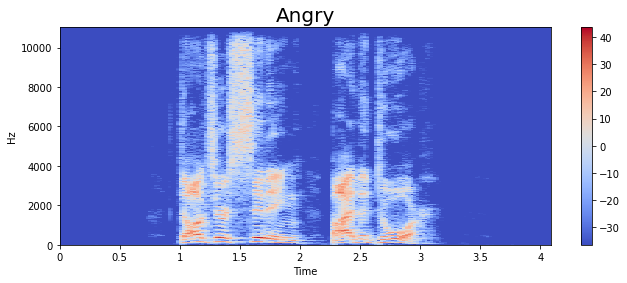

In [33]:
#showing waveplot, spectogram and audio for the emotion "Angry"
emo='Angry'
path = np.array(rav_df['Path'][rav_df['Emotion']==emo])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emo)
spectogram(data, sampling_rate, emo)
Audio(path)

**Feature Extraction along with loading the dataset**

In [3]:
path='/content/drive/MyDrive/RAVDESS Dataset'
lst=[]
for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 

        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      
      except ValueError:
        continue

In [ ]:
#creating a list of first elements(X) and second elemenst(y) using zip 

In [4]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((2880, 40), (2880,))

In [5]:
## Saving X and y as joblib files  as to not load them again with the loop above
import joblib
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/drive/My Drive/Ravdess_model'
savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [6]:
import joblib
X = joblib.load('/content/drive/My Drive/Ravdess_model/X.joblib')
y = joblib.load('/content/drive/My Drive/Ravdess_model/y.joblib')

**Splitting the data into Train and Test sets**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [8]:
x_train = np.expand_dims(X_train, axis=2)
x_test = np.expand_dims(X_test, axis=2)
x_train.shape,x_test.shape

((1929, 40, 1), (951, 40, 1))

In [9]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD,RMSprop

**Modelling the data**

In [10]:
model = Sequential()
model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
model.summary()
#opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 64)            384       
                                                                 
 activation (Activation)     (None, 40, 64)            0         
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           41088     
                                                                 
 activation_1 (Activation)   (None, 10, 128)           0         
                                                        

In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
history=model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
121/121 [==============================] - 4s 18ms/step - loss: 3.4726 - accuracy: 0.1680 - val_loss: 1.9420 - val_accuracy: 0.2397
Epoch 2/200
121/121 [==============================] - 2s 16ms/step - loss: 1.9321 - accuracy: 0.2535 - val_loss: 1.8479 - val_accuracy: 0.2818
Epoch 3/200
121/121 [==============================] - 2s 16ms/step - loss: 1.8447 - accuracy: 0.2841 - val_loss: 1.7740 - val_accuracy: 0.3428
Epoch 4/200
121/121 [==============================] - 2s 16ms/step - loss: 1.7444 - accuracy: 0.3473 - val_loss: 1.7356 - val_accuracy: 0.3302
Epoch 5/200
121/121 [==============================] - 2s 17ms/step - loss: 1.6834 - accuracy: 0.3696 - val_loss: 1.6947 - val_accuracy: 0.3828
Epoch 6/200
121/121 [==============================] - 2s 17ms/step - loss: 1.5817 - accuracy: 0.4121 - val_loss: 1.6297 - val_accuracy: 0.3922
Epoch 7/200
121/121 [==============================] - 2s 17ms/step - loss: 1.5016 - accuracy: 0.4391 - val_loss: 1.4917 - val_accuracy:

**Plotting Training & Testing Loss & Accuracy**

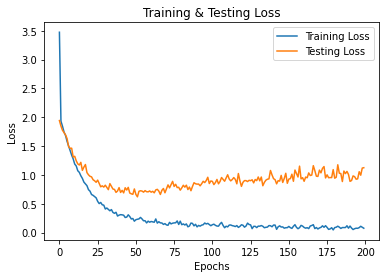

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.show()

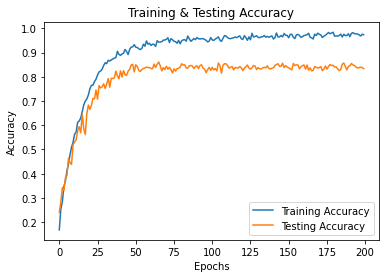

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='lower right')
plt.show()

In [45]:
predict = model.predict(X_test)
predict = np.argmax(predict,axis=1)
predict

array([7, 2, 0, 6, 1, 1, 6, 0, 7, 5, 0, 1, 1, 7, 4, 5, 1, 5, 2, 6, 6, 6,
       5, 5, 2, 5, 3, 5, 5, 4, 4, 7, 7, 2, 0, 0, 1, 0, 7, 7, 7, 2, 1, 0,
       1, 5, 6, 6, 5, 5, 1, 2, 2, 6, 6, 1, 5, 3, 2, 7, 4, 3, 2, 6, 4, 3,
       5, 6, 2, 3, 4, 1, 1, 4, 0, 1, 3, 0, 2, 0, 4, 6, 2, 1, 5, 5, 7, 1,
       3, 6, 6, 2, 1, 6, 2, 6, 1, 0, 3, 3, 3, 6, 7, 4, 1, 5, 6, 2, 4, 4,
       0, 7, 4, 6, 5, 1, 7, 7, 6, 5, 3, 1, 3, 3, 5, 2, 1, 1, 5, 1, 3, 4,
       3, 0, 2, 3, 1, 4, 5, 6, 3, 6, 1, 5, 3, 6, 6, 6, 3, 3, 2, 0, 0, 3,
       6, 1, 0, 6, 3, 2, 4, 0, 3, 5, 0, 2, 3, 5, 7, 4, 4, 4, 5, 5, 6, 1,
       7, 7, 7, 7, 7, 3, 2, 3, 1, 7, 3, 3, 4, 2, 5, 2, 3, 6, 7, 6, 1, 1,
       7, 7, 5, 1, 7, 4, 2, 4, 6, 0, 0, 2, 3, 7, 5, 4, 7, 6, 6, 5, 7, 5,
       3, 6, 0, 6, 3, 0, 5, 5, 3, 2, 7, 7, 0, 1, 2, 6, 0, 6, 4, 5, 7, 3,
       5, 7, 7, 3, 3, 4, 1, 5, 7, 5, 7, 0, 4, 4, 2, 6, 6, 0, 7, 2, 7, 5,
       3, 4, 2, 1, 4, 3, 4, 0, 1, 4, 1, 6, 3, 7, 1, 3, 5, 3, 7, 6, 4, 2,
       3, 2, 4, 6, 1, 3, 6, 3, 0, 3, 4, 4, 7, 6, 3,

In [46]:
Y_test = y_test.astype(int)
Y_test

array([7, 2, 0, 4, 1, 1, 6, 0, 7, 5, 0, 1, 1, 7, 4, 5, 1, 5, 2, 6, 6, 6,
       1, 5, 2, 5, 3, 5, 5, 4, 2, 7, 2, 2, 0, 3, 1, 0, 7, 7, 2, 2, 0, 0,
       2, 5, 6, 6, 5, 5, 1, 2, 2, 6, 6, 1, 5, 3, 2, 7, 4, 1, 7, 2, 4, 3,
       5, 6, 2, 3, 4, 1, 1, 4, 0, 1, 3, 0, 2, 0, 4, 7, 2, 1, 5, 5, 7, 1,
       3, 2, 6, 2, 1, 6, 4, 6, 1, 0, 3, 3, 3, 6, 7, 4, 1, 5, 6, 2, 4, 4,
       0, 7, 4, 6, 5, 1, 4, 7, 6, 5, 3, 1, 5, 5, 5, 2, 1, 1, 5, 1, 3, 4,
       3, 0, 2, 3, 1, 4, 5, 6, 3, 6, 1, 5, 2, 6, 6, 6, 3, 3, 4, 0, 1, 3,
       6, 1, 0, 6, 2, 2, 4, 5, 3, 2, 0, 2, 3, 5, 5, 4, 4, 4, 5, 5, 6, 1,
       7, 7, 7, 3, 4, 3, 2, 6, 1, 5, 2, 3, 4, 2, 5, 2, 3, 6, 7, 6, 2, 3,
       7, 7, 5, 1, 7, 4, 2, 4, 6, 0, 0, 2, 5, 5, 5, 4, 4, 6, 6, 5, 7, 5,
       3, 7, 0, 6, 6, 0, 5, 5, 3, 2, 7, 7, 5, 1, 2, 6, 6, 6, 4, 5, 7, 3,
       5, 7, 7, 3, 3, 4, 0, 5, 7, 5, 2, 0, 6, 4, 2, 6, 6, 3, 7, 2, 7, 5,
       3, 4, 2, 1, 4, 3, 4, 0, 1, 4, 1, 6, 3, 7, 1, 3, 5, 3, 7, 0, 6, 2,
       3, 2, 6, 6, 1, 1, 7, 3, 0, 3, 4, 4, 7, 1, 1,

In [47]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        76
           1       0.86      0.85      0.86       135
           2       0.96      0.70      0.81       122
           3       0.76      0.85      0.80       130
           4       0.91      0.85      0.88       116
           5       0.76      0.83      0.80       133
           6       0.85      0.86      0.86       117
           7       0.87      0.89      0.88       122

    accuracy                           0.83       951
   macro avg       0.84      0.83      0.83       951
weighted avg       0.84      0.83      0.83       951



In [51]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(Y_test,predict)
print (matrix)

[[ 63   7   0   2   0   2   2   0]
 [  8 115   0   6   0   2   4   0]
 [  2   4  86  10   4  10   2   4]
 [  2   4   0 110   0  10   2   2]
 [  2   2   2   2  99   3   2   4]
 [  4   2   0  10   0 111   0   6]
 [  4   0   0   2   6   4 101   0]
 [  0   0   2   2   0   4   6 108]]


In [53]:
print("Accuracy of the model : " , model.evaluate(x_test,y_test)[1]*100 , "%")

30/30 [==============================] - 0s 6ms/step - loss: 1.1250 - accuracy: 0.8339
Accuracy of the model :  83.38590860366821 %
